In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

# Project Overview

### Goal:
    - The goal of this project is to develop a effective model which can use simple customer features to accurately predict client churn. 


### Business Utility: 
    - Identifying clients at high risk of churn gives us actionable intelligence in two phases.
    
        - Potential Customer Identification: By being able to quantify which charateristics make a customer likely to stay or go we can more
        tailor our marketing efforts to attract customers who are more likely to remain customers.
        
        - Utilize targeted marketing and retainment efforts at current customers who are higher risk of churn.

### Methodology: 

    - We will be using a logistic regression model which classifies customers as secure (1), or likely to churn(0).
    - There a few advantages of this model and approach:
        - It is a simple model whcih can easily be tweaked or updated for future use.
        - It is cheap to both build and maintain. 
        - It is intuitive, we input non complicated data about clients (age, gender, credit score etc.) and are able to make predictions with accuracy. 

## Exploratory Data Analysis

### Import and high-level overview

In [5]:
 # Import and preview our data set
df = pd.read_csv('/Users/elias_m/Desktop/Projects /Bank Churn/train.csv')

df_churned = df[df['Exited'] ==1]
df_retained = df[df['Exited'] == 0]

In [6]:
# the following cells give us a high level overview, of the count, average and median of our dataset. 
df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  int64  
 11  IsActiveMember   165034 non-null  int64  
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 17.6+ MB


### Splitting Data Frames for Easier Manipulation

In [8]:
# Creates a table so we can see absolute and relative difference between churned and reatined clients

df_churned = df[df['Exited'] ==1]
df_retained = df[df['Exited'] == 0]

num_variables = ['CreditScore','Age','Tenure','Balance','NumOfProducts']

average_comparison_table = pd.DataFrame({
    'retained': df_retained[num_variables].mean(),
    'churned': df_churned[num_variables].mean(),
})
average_comparison_table['diff'] = average_comparison_table['churned']-average_comparison_table['retained']

std_churned = df_churned[num_variables].std()
std_retained = df_retained[num_variables].std()

pooled_std = np.sqrt((std_churned**2 + std_retained**2) / 2)

average_comparison_table['Z-Score Diff'] = (average_comparison_table['retained']-average_comparison_table['churned'])/pooled_std

average_comparison_table['relative_diff'] = (average_comparison_table['churned']-average_comparison_table['retained'])/average_comparison_table['retained']

In [9]:
average_comparison_table

,retained,churned,diff,Z-Score Diff,relative_diff
CreditScore,657.590710,652.220469,-5.370241,0.066741,-0.008167
Age,36.560480,43.958478,7.397997,-0.861550,0.202350
Tenure,5.048796,4.914378,-0.134418,0.047779,-0.026624
Balance,51255.807752,71209.978085,19954.170333,-0.319682,0.389306
NumOfProducts,1.615273,1.327854,-0.287419,0.491911,-0.177938


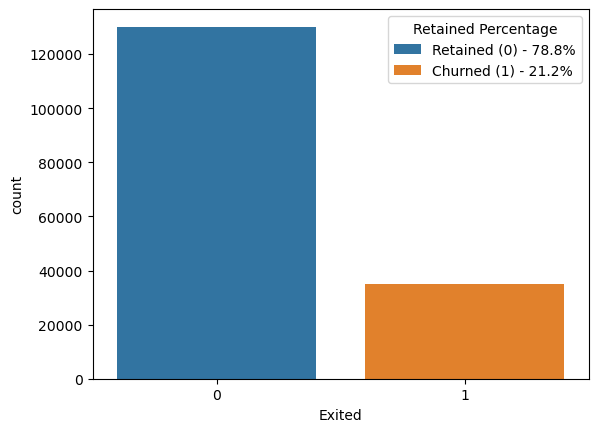

In [89]:
exit_df = pd.DataFrame({'portion':df.Exited.value_counts(normalize= True),
                        'counts':df['Exited'].value_counts()})
exit_df

sns.countplot(data=df, x='Exited',hue = 'Exited')
labels = [f'Retained (0) - {counts[0]/total:.1%}', f'Churned (1) - {counts[1]/total:.1%}']
plt.legend(title='Retained Percentage', labels=labels)


plt.show()

## Initial Findings

    - Two data points jump out as significant predictors of churn.
        - Age
        - Balance
    - This trend must be brought to the attention of appropriate executes and relevant teams.

### Visualizations

In [65]:
variables = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

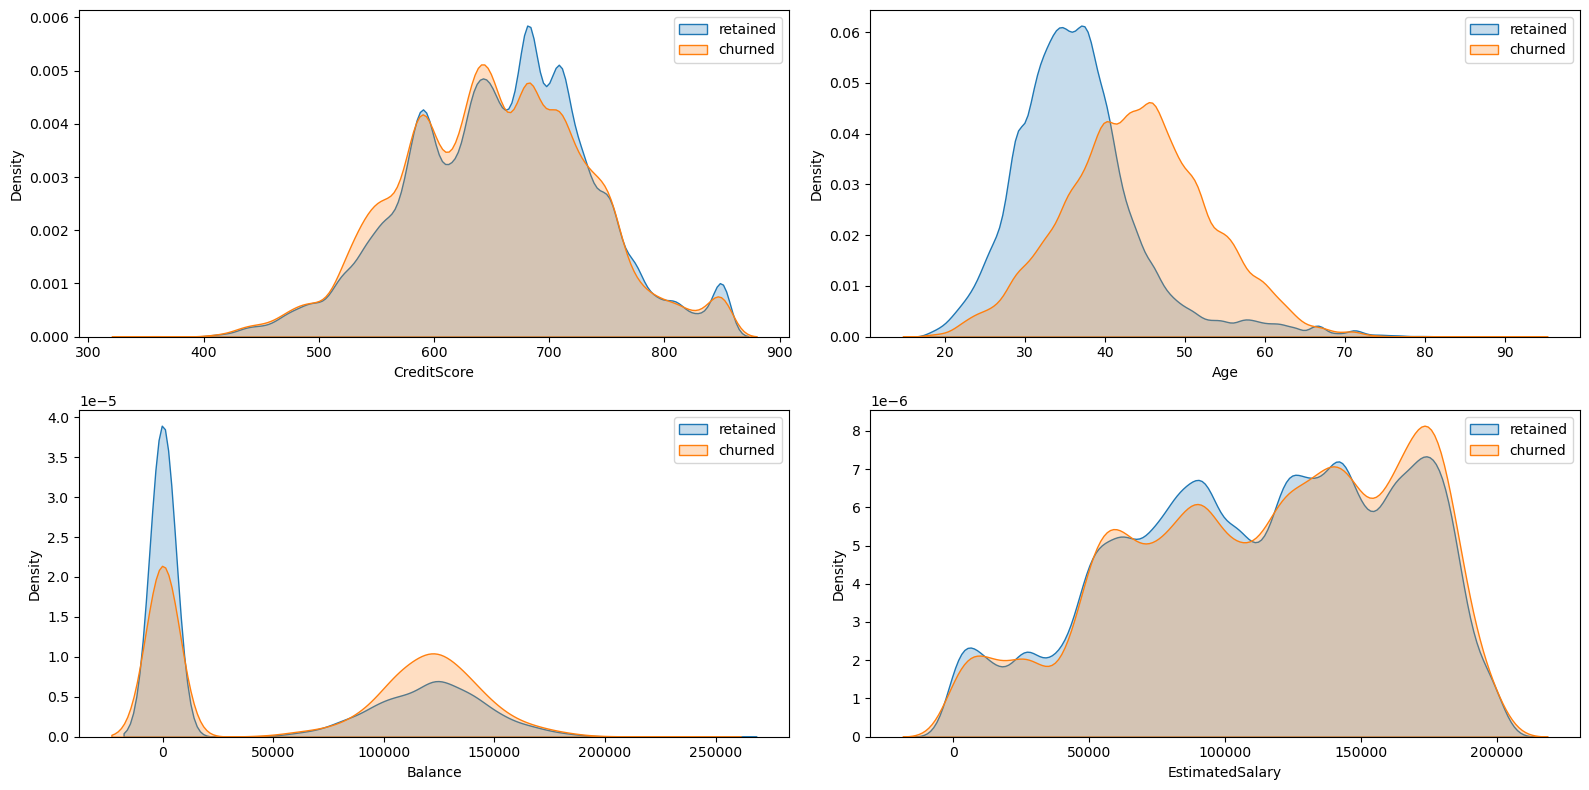

In [67]:
def kde_comps(df_retained, df_exited, columns):
    fig, axes = plt.subplots(2,2, figsize=(16, 8))
    axes = axes.flatten()  # Convert 2x2 array to 1D for easy indexing
    
    for i, col in enumerate(columns):
        ax = axes[i]
        sns.kdeplot(df_retained[col], fill=True, ax=ax, label='retained')
        sns.kdeplot(df_exited[col], fill=True, ax=ax, label='churned')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
kde_comps(df_retained,df_exited,variables)

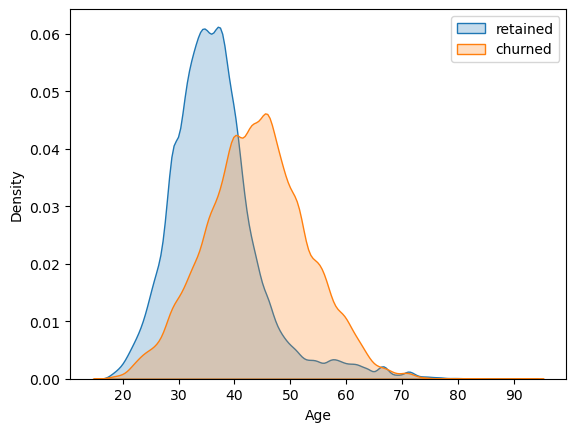

In [14]:


fig1,ax1 = plt.subplots()
sns.kdeplot(df_retained['Age'],fill = True,ax=ax1,label='retained')
sns.kdeplot(df_exited['Age'], fill = True,ax=ax1,label='churned')

ax1.legend()

plt.show()

In [ ]:
def kde_comps(df_retained, df_exited, columns):
    fig, axes = plt.subplots(2,2, figsize=(16, 8))
    axes = axes.flatten()  # Convert 2x2 array to 1D for easy indexing
    
    for i, col in enumerate(columns):
        ax = axes[i]
        sns.kdeplot(df_retained[col], fill=True, ax=ax, label='retained')
        sns.kdeplot(df_exited[col], fill=True, ax=ax, label='churned')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
kde_comps(df_retained,df_exited,variables)

In [16]:
exit_df = pd.DataFrame({'portion':df.Exited.value_counts(normalize= True),
                        'counts':df['Exited'].value_counts()})
exit_df

,portion,counts
Exited,,
0,0.788401,130113
1,0.211599,34921


In [17]:
df_corr = df.drop('CustomerId', axis = 1)

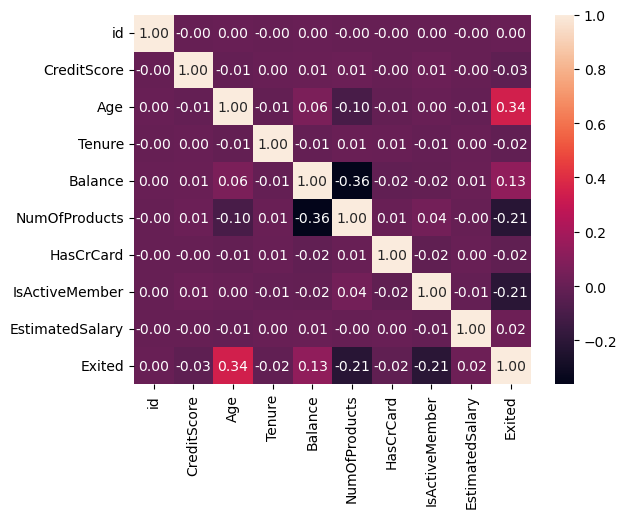

In [18]:
sns.heatmap(data=df_corr.corr(numeric_only=True), annot=True,fmt = '.2f')
plt.show()

In [19]:
df_corr.corr(numeric_only=True)['Exited'].sort_values(ascending=False)

Exited             1.000000
Age                0.340768
Balance            0.129743
EstimatedSalary    0.018827
id                 0.002512
Tenure            -0.019565
HasCrCard         -0.022141
CreditScore       -0.027383
IsActiveMember    -0.210237
NumOfProducts     -0.214554
Name: Exited, dtype: float64

In [20]:
df_men = df[df['Gender'] ==  'Male']
df_women = df[df['Gender'] == 'Female']

In [21]:


df_corr_women = df_women.drop('CustomerId', axis =1)
df_corr_women.corr(numeric_only=True)['Exited'].sort_values(ascending=False)

Exited             1.000000
Age                0.367297
Balance            0.134939
EstimatedSalary    0.028381
id                 0.003586
HasCrCard         -0.013541
Tenure            -0.019468
CreditScore       -0.027525
IsActiveMember    -0.232528
NumOfProducts     -0.235217
Name: Exited, dtype: float64

In [22]:
df_corr_men = df_men.drop('CustomerId', axis =1)
df_corr_men.corr(numeric_only=True)['Exited'].sort_values(ascending=False)

Exited             1.000000
Age                0.306142
Balance            0.124665
EstimatedSalary    0.008012
id                 0.002135
Tenure            -0.017725
CreditScore       -0.027418
HasCrCard         -0.029168
IsActiveMember    -0.186243
NumOfProducts     -0.192385
Name: Exited, dtype: float64

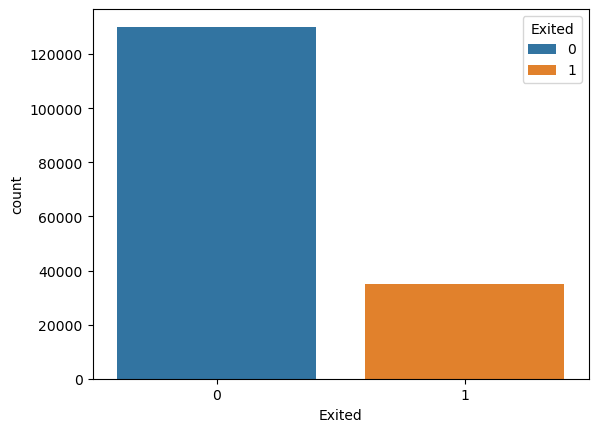

In [23]:
exit_df = pd.DataFrame({'portion':df.Exited.value_counts(normalize= True),
                        'counts':df['Exited'].value_counts()})
exit_df

sns.countplot(data=df, x='Exited',hue = 'Exited')
plt.show()

In [24]:
df.groupby('Exited')['Age'].mean()

Exited
0    36.560480
1    43.958478
Name: Age, dtype: float64

<Axes: xlabel='Exited', ylabel='Age'>

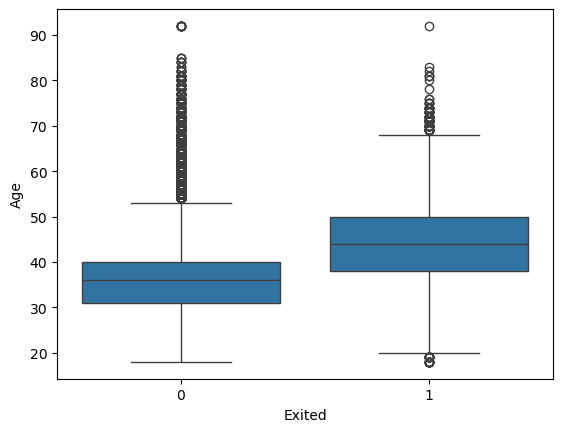

In [25]:
sns.boxplot(data=df,x='Exited',y='Age')


In [26]:
# Here we seperate the data into sets of churned and non_churned customers

In [27]:
df_exited = df[df['Exited']==1]

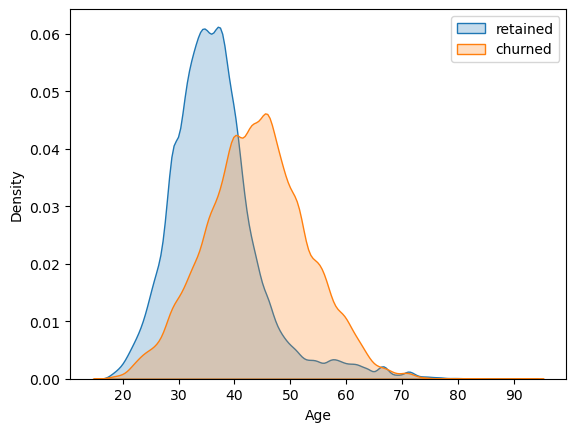

In [28]:
df_exited = df[df['Exited']==1]
df_retained = df[df['Exited']==0]

fig1,ax1 = plt.subplots()
sns.kdeplot(df_retained['Age'],fill = True,ax=ax1,label='retained')
sns.kdeplot(df_exited['Age'], fill = True,ax=ax1,label='churned')

ax1.legend()

plt.show()

In [29]:
df_men.Exited.value_counts()

Exited
0    78334
1    14816
Name: count, dtype: int64

In [30]:
df_women.Exited.value_counts()

Exited
0    51779
1    20105
Name: count, dtype: int64

In [31]:
print(f"Women exited at a rate of {round(df_women.Exited.value_counts()[1]/df_women.Exited.value_counts().sum(),2)}%, /n while men exited at a rate of {round(df_men.Exited.value_counts()[1]/df_men.Exited.value_counts().sum(),2)}%")

Women exited at a rate of 0.28%, /n while men exited at a rate of 0.16%


In [32]:
df.Gender.value_counts()

Gender
Male      93150
Female    71884
Name: count, dtype: int64

In [33]:
df.groupby('Gender')['Balance'].mean()

Gender
Female    56529.169653
Male      54666.964330
Name: Balance, dtype: float64

In [34]:
df.groupby('Gender')['Age'].mean()

Gender
Female    38.763207
Male      37.634068
Name: Age, dtype: float64

In [35]:
df_exited.groupby('Gender')['EstimatedSalary'].mean()

Gender
Female    115322.571535
Male      113153.974419
Name: EstimatedSalary, dtype: float64

#### Exploration Summary

- The strongest indicator a customer will remain is account activity, followed by the number of products they have with us.
- Alarmingly, higher income and account balances are associated with higher churn.
- Age is the strongest predictor of churn, domain knowledge is need to evaluate the cause.
- Women churn 50% more frequently than men!
- Age and Salary are significantly stronger for women than for men. 

      - Questions:
          - Are customers passing away an explanation for age's correlation with churn?
          - Is this explained by income and account balance increasing with age?
          - Also, something that requires exploration is why increased balances and salary are increased with higher churn. Losing high value clients is an area of concern


## Classification Models

### Data Transformation Pipeline

Before we can use it for our model our data must be transformed. We will scale our numerical values and one_hot_encode our categorical data. 

In [38]:
#Here we will import the tools needed for manipulating our data and implementing our model
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import stats

In [39]:
df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1,0,181449.98,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1,1,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1,0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1,1,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1,1,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1,1,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0,0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1,1,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0,1,71173.03,0


In [40]:
# Separating our features from our target variables and splitting our data into training and testing sets

df_model = df.drop(['id','CustomerId'],axis = 1)

X = df_model.drop('Exited',axis = 1)
y = df_model['Exited']

X_train, X_test, y_train, y_test = train_test_split(

X, y, test_size=0.25, random_state=42)



In [41]:
X_train.columns

Index(['Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary'],
      dtype='object')

In [42]:

# For processing purposes we must identify our numerical and categorical features

categorical_columns = ['Geography','Gender']
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']



In [43]:
# frist we will construct our preprocessor, for scaling/encoding our numerical/categorical variables respectively

preprocessor = ColumnTransformer([
    ('num_columns',StandardScaler(),numerical_columns),
    ('cat_columns',OneHotEncoder(drop='first'),categorical_columns),
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 450))
    ])


In [44]:
# now we will fit our training data

model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_columns',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat_columns',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(max_iter=450))])

In [45]:
y_pred = model.predict(X_test)

## Initial Model Performance

In [47]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay

In [48]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.8366174652803025

In [49]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     32638
           1       0.70      0.39      0.50      8621

    accuracy                           0.84     41259
   macro avg       0.78      0.67      0.70     41259
weighted avg       0.82      0.84      0.82     41259



Our model had an accuracy of 84%, however with an imbalanced data set this is not particularly useful. Performance on the adverse data set was poor with an f1-score of 0.50 for clients who churned. 

## Optimizing Model Accuracy by Adjusting Hyperparameters
Our model needs improvments. We will attempt to tune it by using a CV Grid Search to identify optimal hyperparemeters

In [52]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'classifier__penalty': ['l2','l1'],
    'classifier__C': [0.0001,0.001,0.05,0.1,1,10,100],
    'classifier__solver': ['liblinear']
    },
    {
        'classifier__penalty': ['elasticnet'],
        'classifier__C': [0.0001, 0.001, 0.05, 0.1, 1, 10, 100],
        'classifier__l1_ratio': [0.1, 0.25, 0.5, 0.9, 0.99],
        'classifier__solver': ['saga']
    }
        ]
        
gridsearch = GridSearchCV(estimator=model,param_grid=param_grid,cv=6, scoring='accuracy')

gridsearch.fit(X_train,y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_columns',
                                                                         StandardScaler(),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'HasCrCard',
                                                                          'IsActiveMember',
                                                                          'EstimatedSalary']),
                                                                        ('cat_columns',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Geography',
                                                                          'Gender'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=450))]),
             param_grid=[{'classifier__C': [0.0001, 0.001, 0.05, 0.1, 1, 10,
                                            100],
                          'classifier__penalty': ['l2', 'l1'],
                          'classifier__solver': ['liblinear']},
                         {'classifier__C': [0.0001, 0.001, 0.05, 0.1, 1, 10,
                                            100],
                          'classifier__l1_ratio': [0.1, 0.25, 0.5, 0.9, 0.99],
                          'classifier__penalty': ['elasticnet'],
                          'classifier__solver': ['saga']}],
             scoring='accuracy')

In [53]:
gridsearch.best_params_

{'classifier__C': 0.05,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

## Updated Logistic Regressor 

In [55]:
## here we will instantiate our second model with adjusted hyperparamers
preprocessor = ColumnTransformer([
    ('num_columns',StandardScaler(),numerical_columns),
    ('cat_columns',OneHotEncoder(drop='first'),categorical_columns),
])

model_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=0.1,l1_ratio=0.1,penalty='elasticnet',solver='saga'))
    ])

In [56]:
model_2.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_columns',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat_columns',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('classifier',
                 LogisticRegression(C=0.1, l1_ratio=0.1, penalty='elasticnet',
                                    solver='saga'))])

In [57]:
y_pred_2 = model_2.predict(X_test)

## Model 2 Accuracy

In [59]:
accuracy = accuracy_score(y_test,y_pred_2)
accuracy

0.8366174652803025

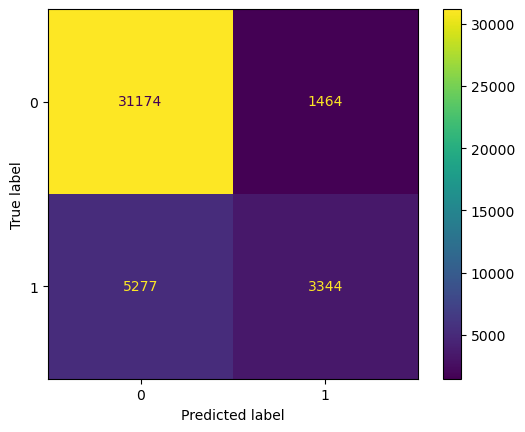

In [60]:
# lets visualize our predictions with a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test,y_pred_2)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

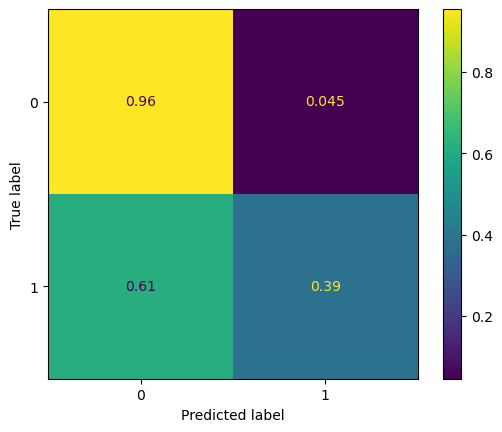

In [61]:
cm_2 = confusion_matrix(y_test,y_pred_2,normalize='true')
cm_display_2= ConfusionMatrixDisplay(confusion_matrix = cm_2)
cm_display_2.plot()
plt.show()

In [62]:
print(classification_report(y_test,y_pred_2))

              precision    recall  f1-score   support

           0       0.86      0.96      0.90     32638
           1       0.70      0.39      0.50      8621

    accuracy                           0.84     41259
   macro avg       0.78      0.67      0.70     41259
weighted avg       0.82      0.84      0.82     41259



### Model 3: XGBoost

In [64]:
from xgboost import XGBClassifier

In [65]:
xgb_predictor = XGBClassifier(objective='binary:logistic')

In [66]:
model_3 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(objective='binary:logistic'))
    ])

In [67]:
model_3.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_columns',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat_columns',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsamp...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [68]:
y_pred_3 = model_3.predict(X_test)

In [69]:
print(classification_report(y_test,y_pred_3))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     32638
           1       0.73      0.56      0.63      8621

    accuracy                           0.87     41259
   macro avg       0.81      0.75      0.78     41259
weighted avg       0.86      0.87      0.86     41259



In [70]:

xgb_predictor = XGBClassifier(objective='binary:logistic')


xgb_param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__gamma': [0, 0.1, 0.2],
}

model_4_random_search_xgb = RandomizedSearchCV(model_3, xgb_param_grid, cv=5, scoring='recall')

model_4_random_search_xgb.fit(X_train,y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_columns',
                                                                               StandardScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'HasCrCard',
                                                                                'IsActiveMember',
                                                                                'EstimatedSalary']),
                                                                              ('cat_columns',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Geography',
                                                                                'Gender'])])),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            b...
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   param_distributions={'classifier__colsample_bytree': [0.6,
                                                                         0.8,
                                                                         1.0],
                                        'classifier__gamma': [0, 0.1, 0.2],
                                        'classifier__learning_rate': [0.01,
                                                                      0.05,
                                                                      0.1],
                                        'classifier__max_depth': [3, 5, 7],
                                        'classifier__min_child_weight': [1, 3,
                                                                         5],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__subsample': [0.6, 0.8,
                                                                  1.0]},
                   scoring='recall')

In [81]:
model_4_random_search_xgb.best_params_

{'classifier__subsample': 0.8,
 'classifier__n_estimators': 300,
 'classifier__min_child_weight': 5,
 'classifier__max_depth': 5,
 'classifier__learning_rate': 0.1,
 'classifier__gamma': 0,
 'classifier__colsample_bytree': 1.0}

In [85]:
y_pred_4 = model_4_random_search_xgb.predict(X_test)

## Model 4 Accuracy 

In [87]:
print(classification_report(y_test,y_pred_4))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     32638
           1       0.73      0.57      0.64      8621

    accuracy                           0.87     41259
   macro avg       0.81      0.76      0.78     41259
weighted avg       0.86      0.87      0.86     41259



## Models Stratified by Gender

Men and Women churn and significantly different rates. We're gonna see how the model performs when fit after stratifying by gender.

In [89]:

df_model_men = df.drop(['id','CustomerId'],axis = 1)

X_men = df_model_men.drop('Exited',axis = 1)
y_men = df_model_men['Exited']

X_train, X_test, y_train, y_test = train_test_split(

X_men, y_men, test_size=0.25, random_state=42)


In [261]:

df_model_men = df.drop(['id','CustomerId'],axis = 1)

df_model_men = df_model_men[df_model_men['Gender']=='Male']

X_men = df_model_men.drop('Exited',axis = 1)
y_men = df_model_men['Exited']


X_train, X_test, y_train, y_test = train_test_split(

X_men, y_men, test_size=0.25, random_state=42)




model_3.fit(X_train,y_train)







xgb_param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__gamma': [0, 0.1, 0.2],
}

model_5_men = RandomizedSearchCV(model_3, xgb_param_grid, cv=5, scoring='recall')

model_5_men.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_columns',
                                                                               StandardScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'HasCrCard',
                                                                                'IsActiveMember',
                                                                                'EstimatedSalary']),
                                                                              ('cat_columns',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Geography',
                                                                                'Gender'])])),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            b...
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   param_distributions={'classifier__colsample_bytree': [0.6,
                                                                         0.8,
                                                                         1.0],
                                        'classifier__gamma': [0, 0.1, 0.2],
                                        'classifier__learning_rate': [0.01,
                                                                      0.05,
                                                                      0.1],
                                        'classifier__max_depth': [3, 5, 7],
                                        'classifier__min_child_weight': [1, 3,
                                                                         5],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__subsample': [0.6, 0.8,
                                                                  1.0]},
                   scoring='recall')

In [262]:
y_pred_men = model_5_men.predict(X_test)

In [263]:
print(classification_report(y_test,y_pred_men))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93     19515
           1       0.72      0.45      0.56      3773

    accuracy                           0.88     23288
   macro avg       0.81      0.71      0.74     23288
weighted avg       0.87      0.88      0.87     23288



In [109]:
df_model_women = df.drop(['id','CustomerId'],axis = 1)

df_model_women = df_model_women[df_model_women['Gender']=='Female']

X_women = df_model_women.drop('Exited',axis = 1)
y_women = df_model_women['Exited']


X_train, X_test, y_train, y_test = train_test_split(

X_women, y_women, test_size=0.25, random_state=42)



model_3 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(objective='binary:logistic'))
    ])
model_3.fit(X_train,y_train)




xgb_predictor = XGBClassifier(objective='binary:logistic')


xgb_param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__gamma': [0, 0.1, 0.2],
}

model_6_women = RandomizedSearchCV(model_4, xgb_param_grid, cv=5, scoring='recall')

model_6_women.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_columns',
                                                                               StandardScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'HasCrCard',
                                                                                'IsActiveMember',
                                                                                'EstimatedSalary']),
                                                                              ('cat_columns',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Geography',
                                                                                'Gender'])])),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            b...
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   param_distributions={'classifier__colsample_bytree': [0.6,
                                                                         0.8,
                                                                         1.0],
                                        'classifier__gamma': [0, 0.1, 0.2],
                                        'classifier__learning_rate': [0.01,
                                                                      0.05,
                                                                      0.1],
                                        'classifier__max_depth': [3, 5, 7],
                                        'classifier__min_child_weight': [1, 3,
                                                                         5],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__subsample': [0.6, 0.8,
                                                                  1.0]},
                   scoring='recall')

In [264]:
y_pred_women = model_6_women.predict(X_test)

ValueError: Found unknown categories ['Male'] in column 1 during transform

In [ ]:
print(classification_report(y_test,y_pred_women))

## Initial Model Findings: 

### Insofar our most successful model has been an XGBoosted binary classifier with parameters optimized via random search. With a overall accuracy of 87%. And for the adverserial class (churn) 
#### Precision: 0.74
#### Recall: 0.56 and 
#### f1 score of 0.64

In [ ]:
print(classification_report(y_test,y_pred_4))

## Addressing class imbalance utilizing SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.pipeline import Pipeline as imb_Pipe

In [ ]:
counter = Counter(y_train)
print(f"Before: {counter}")

In [ ]:
preprocessor = ColumnTransformer([
    ('num_columns',StandardScaler(),numerical_columns),
    ('cat_columns',OneHotEncoder(drop='first'),categorical_columns),
])

In [ ]:
xgb_predictor = XGBClassifier(objective='binary:logistic')


xgb_param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__gamma': [0, 0.1, 0.2],
}

In [ ]:
smt = SMOTE()

In [248]:
model_7_smote = RandomizedSearchCV(xgb_predictor, xgb_param_grid, cv=5, scoring='f1_score')

In [250]:
imb_pipeline = imb_Pipe([('preprocessor',preprocessor),('smt',smt),('classifier',xgb_predictor)])

In [252]:
model_7_smote = RandomizedSearchCV(
    estimator=imb_pipeline,
    param_distributions=xgb_param_grid,
    scoring='recall',
    cv=5,
    n_iter=20,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [254]:
model_7_smote.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_columns',
                                                                               StandardScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'HasCrCard',
                                                                                'IsActiveMember',
                                                                                'EstimatedSalary']),
                                                                              ('cat_columns',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Geography',
                                                                                'Gender'])])),
                                             ('smt', SMOTE()),
                                             ('classifier',
                                              XGBClassifier(b...
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__colsample_bytree': [0.6,
                                                                         0.8,
                                                                         1.0],
                                        'classifier__gamma': [0, 0.1, 0.2],
                                        'classifier__learning_rate': [0.01,
                                                                      0.05,
                                                                      0.1],
                                        'classifier__max_depth': [3, 5, 7],
                                        'classifier__min_child_weight': [1, 3,
                                                                         5],
                                        'classifier__n_estimators': [100, 200,
                                                                     300]},
                   random_state=42, scoring='recall', verbose=1)

In [256]:
smote_pred = model_7_smote.predict(X_test)

In [258]:
print(classification_report(y_test,smote_pred))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85     12918
           1       0.61      0.81      0.70      5053

    accuracy                           0.80     17971
   macro avg       0.76      0.80      0.78     17971
weighted avg       0.83      0.80      0.81     17971



## Summary and Evaluation

We were able to glean some interesting information regarding relationships betwen client age,income, and balance with churn. These require further evaluation and discussion with marketing and appropriate executives. Development of a more accurate model requires further exploration and differenet methodologies, possibly including Neural Networks and/or RandomForestNetworks